In [106]:
import numpy as np
import random
from PIL import Image
from abc import ABC, abstractmethod
from collections import defaultdict

random.seed(1)
np.random.seed(1)

SPRITE_SIZE = 64

class GridEntity:
    sprite_cache = defaultdict(dict)
    last_id = 0

    @classmethod
    def preload_sprites(cls, colors_dict, orientations, sprite_path, sprite_size):
        for entity_type, colors in colors_dict.items():
            for color in colors:
                for orientation in orientations:
                    if entity_type == 'boulders':
                        img_path = f'{sprite_path}{entity_type}/boulder_{str(color)}.png'
                    elif entity_type == 'cars':
                        img_path = f'{sprite_path}{entity_type}/car_{str(color)}_(255, 255, 0).png'
                    elif entity_type == 'lights':
                        for state in ['red', 'green']:
                            img_path = f'{sprite_path}{entity_type}/light_{str(color)}_{state}.png'
                            cls._load_single_sprite(entity_type, color, orientation, img_path, state, sprite_size)
                        continue
                    cls._load_single_sprite(entity_type, color, orientation, img_path, None, sprite_size)

    @classmethod
    def _load_single_sprite(cls, entity_type, color, orientation, img_path, state, sprite_size):
        try:
            img = Image.open(img_path).convert('RGBA').resize((sprite_size, sprite_size))
            rotation = {'up': 180, 'down': 0, 'left': 270, 'right': 90}[orientation]
            cls.sprite_cache[entity_type][(str(color), orientation, state)] = img.rotate(rotation)
        except FileNotFoundError:
            print(f"File not found: {img_path}")

    @classmethod
    def load_sprite(cls, entity_type, color, orientation, state=None):
        return cls.sprite_cache[entity_type][(str(color), orientation, state)]

    def __init__(self, x, y, entity_type, color, orientation=None, speed=1, sprite_path='sprites/', sprite_size=64):
        self.id = GridEntity.last_id
        GridEntity.last_id += 1
        self.x = x
        self.y = y
        self.entity_type = entity_type
        self.color = color
        self.orientation = orientation
        self.speed = speed
        self.sprite_size = sprite_size
        self.sprite_path = sprite_path
        self.state = None if entity_type != 'lights' else 'red'
        self.sprite = self.load_sprite(entity_type, color, orientation, self.state)

    def set_position(self, x, y):
        self.x = x
        self.y = y

    def move_forward(self):
        if self.orientation == 'up':
            self.y -= self.speed
        elif self.orientation == 'down':
            self.y += self.speed
        elif self.orientation == 'left':
            self.x -= self.speed
        elif self.orientation == 'right':
            self.x += self.speed

    def turn_left(self):
        turns = {'up': 'left', 'left': 'down', 'down': 'right', 'right': 'up'}
        self.orientation = turns[self.orientation]
        self.sprite = self.sprite.rotate(90)

    def turn_right(self):
        turns = {'up': 'right', 'right': 'down', 'down': 'left', 'left': 'up'}
        self.orientation = turns[self.orientation]
        self.sprite = self.sprite.rotate(-90)

    def __repr__(self):
        return f"{self.entity_type} at ({self.x}, {self.y}) facing {self.orientation}"

class Vehicle(GridEntity):
    def __init__(self, x, y, color, size, orientation, speed):
        super().__init__(x, y, 'cars', color, orientation, speed)
        self.size = size
        
    def predict_next_position(self):
        dx, dy = 0, 0
        if self.orientation == 'up':
            dy = -self.speed
        elif self.orientation == 'down':
            dy = self.speed
        elif self.orientation == 'left':
            dx = -self.speed
        elif self.orientation == 'right':
            dx = self.speed
        return self.x + dx, self.y + dy

    def set_speed(self, speed):
        self.speed = speed

    def intervene_rotation(self, new_orientation):
        if new_orientation not in ['up', 'down', 'left', 'right']:
            raise ValueError("Invalid orientation")
        self.orientation = new_orientation
        self.sprite = self.load_sprite(self.entity_type, self.color, self.orientation)


class Pedestrian(GridEntity):
    def __init__(self, x, y, color, orientation=None, speed=1):
        super().__init__(x, y, 'pedestrians', color, orientation, speed)
    # ... Rest of the Pedestrian class ...

    def predict_random_walk(self):
        dx, dy = np.random.choice([-1, 0, 1]), np.random.choice([-1, 0, 1])
        return self.x + dx, self.y + dy

    def move_to(self, x, y):
        self.x = x
        self.y = y

class Obstacle(GridEntity):
    def __init__(self, x, y, color, orientation='down', speed=0):
        super().__init__(x, y, 'boulders', color, orientation, speed)
    
    def move_to(self, x, y):
        self.x = x
        self.y = y
    

class TrafficLight(GridEntity):
    def __init__(self, x, y, state, color, orientation=None, speed=0, frequency=None):
        super().__init__(x, y, 'lights', color, orientation, speed)
        self.state = state
        self.frequency = frequency
        self.update_sprite()

    def update_sprite(self):
        self.sprite = self.load_sprite('lights', self.color, self.orientation, self.state)

    def update(self, step):
        if not self.frequency:
            return
        if step % sum(self.frequency) < self.frequency[0]:
            self.state = 'red'
        else:
            self.state = 'green'
        self.update_sprite()

    def change_orientation(self, new_orientation):
        if new_orientation not in ['up', 'down', 'left', 'right']:
            raise ValueError("Invalid orientation")
        self.orientation = new_orientation
        self.update_sprite()
    
    def _populate_tl_sprite_cache(self):
        # Iterate over each orientation and state to create and cache sprites
        for orient in ['up', 'down', 'left', 'right']:
            # Load the base sprite for the current orientation
            base_sprite = self.load_sprite(self.symbol, orient, self.sprite_path, self.sprite_size)

            # Create and cache the red and green sprites for this orientation
            red_sprite = Image.blend(base_sprite, Image.new('RGBA', base_sprite.size, (255, 0, 0, 128)), 0.5)
            green_sprite = Image.blend(base_sprite, Image.new('RGBA', base_sprite.size, (0, 255, 0, 128)), 0.5)

            # Cache the sprites with keys as (orientation, state)
            self.traffic_light_sprite_cache[(orient, 'red')] = red_sprite
            self.traffic_light_sprite_cache[(orient, 'green')] = green_sprite

    def intervene_state(self):
        self.state = 'green' if self.state == 'red' else 'red'
        self.update_sprite()
    
    def __repr__(self):
        return f"Traffic light at ({self.x}, {self.y}) facing {self.orientation} with state {self.state}."


class Gridworld:
    @classmethod
    def get_possible_intervention(cls, entity):
        if isinstance(entity, Vehicle):
            return ['turn']
        elif isinstance(entity, TrafficLight):
            return ['change_orientation', 'change_state']
        elif isinstance(entity, Pedestrian):
            return ['move_to']
        elif isinstance(entity, Obstacle):
            return ['move_to']

    @property
    def entities(self):
        return [entity for entities in self.entity_map.values() for entity in entities]

    def __init__(self, width, height, sprite_size=SPRITE_SIZE):
        self.width = width
        self.height = height
        self.grid = np.full((height, width), ' ', dtype='<U1')
        self.entity_map = defaultdict(list)  # For efficient spatial queries
        self.entity_groups = None
        self.step_count = 0
        self.sprite_size = sprite_size

    def add_entity(self, entity):
        self.entity_map[(entity.x, entity.y)].append(entity)

    def move_entity(self, entity, new_x, new_y):
        if self.is_cell_free(new_x, new_y) and 0 <= new_x < self.width and 0 <= new_y < self.height:
            self.entity_map[(entity.x, entity.y)].remove(entity)
            entity.set_position(new_x, new_y)
            self.entity_map[(new_x, new_y)].append(entity)

    def update_grid(self):
        self.grid.fill(' ')
        for entity in self.entities:
            if 0 <= entity.x < self.width and 0 <= entity.y < self.height:
                self.grid[entity.y][entity.x] = entity.symbol

    def display(self):
        for row in self.grid:
            print(' '.join(row))

    def step(self):
        if not self.entity_groups:
            self._build_entity_groups()
        self.step_count += 1

        # Update traffic lights based on step count
        # for position, entities in list(self.entity_map.items()):
        #     for entity in entities:
        #         if isinstance(entity, TrafficLight):
        #             entity.update(self.step_count)

        # Enforce traffic rules
        self.enforce_traffic_rules()
        # self.randomly_change_car_orientation()
        # Temporary structure to store entity movements
        movements = []

        # Update each entity
        for position, entities in list(self.entity_map.items()):
            for entity in entities:
                if isinstance(entity, Vehicle):
                    next_x, next_y = entity.predict_next_position()
                    movements.append((entity, next_x, next_y))
                elif isinstance(entity, Pedestrian):
                    next_x, next_y = entity.predict_random_walk()
                    movements.append((entity, next_x, next_y))
                # elif isinstance(entity, TrafficLight):
                #     entity.update(self.step_count)

        # Apply movements
        for entity, next_x, next_y in movements:
            self.move_entity(entity, next_x, next_y)

        # Handle collisions
        self.handle_collisions()

    def intervene(self, entity, intervention, **intervention_args):
        if isinstance(entity, Vehicle):
            if intervention == 'turn':
                entity.intervene_rotation(intervention_args['new_orientation'])
        elif isinstance(entity, TrafficLight):
            if intervention == 'change_orientation':
                entity.change_orientation(intervention_args['new_orientation'])
            elif intervention == 'change_state':
                entity.intervene_state()
        elif isinstance(entity, Pedestrian):
            if intervention == 'move_to':
                self.move_entity(entity, intervention_args['x'], intervention_args['y'])
        elif isinstance(entity, Obstacle):
            if intervention == 'move_to':
                self.move_entity(entity, intervention_args['x'], intervention_args['y'])
    
    def random_intervention(self):
        entity = random.choice(self.entities)
        possible_interventions = self.get_possible_intervention(entity)
        intervention = random.choice(possible_interventions)
        if intervention == 'turn':
            new_orientation = random.choice(['up', 'down', 'left', 'right'])
            self.intervene(entity, intervention, new_orientation=new_orientation)
        elif intervention == 'change_orientation':
            new_orientation = random.choice(['up', 'down', 'left', 'right'])
            self.intervene(entity, intervention, new_orientation=new_orientation)
        elif intervention == 'change_state':
            self.intervene(entity, intervention)
        elif intervention == 'move_to':
            # Pick a random cell around the entity that is free
            x, y = entity.x, entity.y
            possible_moves = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
            possible_moves = [(x, y) for x, y in possible_moves if self.is_cell_free(x, y)]
            if possible_moves:
                new_x, new_y = random.choice(possible_moves)
                self.intervene(entity, intervention, x=new_x, y=new_y)
    
    def semi_random_intervention(self, intervention_probabilities = {
            'Vehicle': 0.2, 'TrafficLight': 0.4, 'Obstacle': 0.1, 'None': 0.3
        }):
        """
        Perform semi-random interventions with original logic and track interventions
        as a binary vector corresponding to the causals, including action codes.
        """
        causals = self.get_causals()
        binary_interventions = {key: 0 for key in causals.keys()}  # Use dictionary for binary interventions
        action_code = None

        # Define the action mapping
        ACTION_MAPPING = {'turn': 1, 'change_state': 2, 'move_to': 3}
        
        assert sum(intervention_probabilities.values()) == 1, "Intervention probabilities must sum to 1."

        # Select an entity type based on the defined probabilities
        entity_type = np.random.choice(list(intervention_probabilities.keys()), p=list(intervention_probabilities.values()))
        
        if entity_type == 'None':
            return action_code, binary_interventions
        
        # Select a random entity of the selected type
        entity = random.choice([entity for entity in self.entities if entity.__class__.__name__ == entity_type])
        
        if isinstance(entity, Vehicle):
            next_pos = entity.predict_next_position()
            if not self.is_cell_free(*next_pos):
                obstacle = self.get_entity_at_position(*next_pos)
                if obstacle and isinstance(obstacle, Obstacle):
                    # Move the obstacle
                    possible_moves = self.get_free_cells_around_entity(obstacle)
                    if possible_moves:
                        new_x, new_y = random.choice(possible_moves)
                        self.intervene(obstacle, 'move_to', x=new_x, y=new_y)
                        binary_interventions[f'obstacle_{obstacle.color}_position'] = 1
                        action_code = (obstacle.x, obstacle.y, ACTION_MAPPING['move_to'])
                else:
                    # Turn the car
                    current_orientation = entity.orientation
                    new_orientation_choices = {'up': ['left', 'right'], 'down': ['left', 'right'], 'left': ['up', 'down'], 'right': ['up', 'down']}[current_orientation]
                    new_orientation = random.choice(new_orientation_choices)
                    self.intervene(entity, 'turn', new_orientation=new_orientation)
                    binary_interventions[f'vehicle_{entity.color}_orientation'] = 1
                    action_code = (entity.x, entity.y, ACTION_MAPPING['turn'])
            else:
                # Turn the car
                new_orientation = random.choice(['up', 'down', 'left', 'right'])
                self.intervene(entity, 'turn', new_orientation=new_orientation)
                binary_interventions[f'vehicle_{entity.color}_orientation'] = 1
                action_code = (entity.x, entity.y, ACTION_MAPPING['turn'])
        elif isinstance(entity, TrafficLight):
            # Change the state of the traffic light
            self.intervene(entity, 'change_state')
            binary_interventions[f'trafficlight_{entity.color}_state'] = 1
            action_code = (entity.x, entity.y, ACTION_MAPPING['change_state'])
        elif isinstance(entity, Obstacle):
            # Move the obstacle to a random free cell
            possible_moves = self.get_free_cells_around_entity(entity)
            if possible_moves:
                new_x, new_y = random.choice(possible_moves)
                self.intervene(entity, 'move_to', x=new_x, y=new_y)
                binary_interventions[f'obstacle_{entity.color}_position'] = 1
                action_code = (entity.x, entity.y, ACTION_MAPPING['move_to'])

        return action_code, binary_interventions

    
    def randomly_change_car_orientation(self):
        for position, entities in list(self.entity_map.items()):
            for entity in entities:
                if isinstance(entity, Vehicle):
                    if random.random() < 0.1:
                        if random.random() < 0.5:
                            entity.turn_left()
                        else:
                            entity.turn_right()                        


    def move_vehicle(self, vehicle):
        next_x, next_y = vehicle.predict_next_position()
        self.move_entity(vehicle, next_x, next_y)

    def move_pedestrian(self, pedestrian):
        next_x, next_y = pedestrian.predict_random_walk()
        self.move_entity(pedestrian, next_x, next_y)

    def handle_collisions(self):
        for pos, entities in self.entity_map.items():
            if len(entities) > 1:
                # Handle collisions between entities at the same position
                for entity1 in entities:
                    for entity2 in entities:
                        if entity1 != entity2:
                            self.resolve_collision(entity1, entity2)

    def resolve_collision(self, entity1, entity2):
        if isinstance(entity1, Vehicle) and isinstance(entity2, Vehicle):
            entity1.set_speed(0)
            entity2.set_speed(0)
            print(f"Collision between {entity1.entity_type} and {entity2.entity_type} at ({entity1.x}, {entity1.y})")

    def enforce_traffic_rules(self):
        for position, entities in list(self.entity_map.items()):
            for entity in entities:
                if isinstance(entity, Vehicle):
                    self.check_traffic_light(entity)

    def check_traffic_light(self, vehicle):
        vehicle.set_speed(1)
        for position, entities in list(self.entity_map.items()):
            for entity in entities:
                if isinstance(entity, TrafficLight):
                    if self.is_light_ahead(vehicle, entity):
                        if entity.state == 'red':
                            vehicle.set_speed(0)
                        else:
                            vehicle.set_speed(1)
                    # else:
                    #     vehicle.set_speed(1)


    def is_light_ahead(self, vehicle, light):
        dx, dy = vehicle.predict_next_position()
        if vehicle.orientation == 'up' and light.orientation == 'down':
            return light.y < vehicle.y and light.x == vehicle.x
        elif vehicle.orientation == 'down' and light.orientation == 'up':
            return light.y > vehicle.y and light.x == vehicle.x
        elif vehicle.orientation == 'left' and light.orientation == 'right':
            return light.x < vehicle.x and light.y == vehicle.y
        elif vehicle.orientation == 'right' and light.orientation == 'left':
            return light.x > vehicle.x and light.y == vehicle.y
        return False

    def is_cell_free(self, x, y):
        return not self.entity_map[(x, y)]

    def get_free_cells_around_entity(self, entity):
        x, y = entity.x, entity.y
        possible_moves = [(x-1, y), (x+1, y), (x, y-1), (x, y+1)]
        possible_moves = [(x, y) for x, y in possible_moves if self.is_cell_free(x, y)]
        return possible_moves

    def get_entity_at_position(self, x, y):
        if self.entity_map[(x, y)]:
            return self.entity_map[(x, y)][0]
        return None

    def render(self):
        sprite_size = self.sprite_size
        env_img = Image.new('RGBA', (self.width * sprite_size, self.height * sprite_size), (255, 255, 255, 0))
        for entities in self.entity_map.values():
            for entity in entities:
                img = entity.sprite
                x, y = entity.x * sprite_size, entity.y * sprite_size
                env_img.paste(img, (x, y), img)
        # Include grid lines
        for i in range(1, self.width):
            env_img.paste((0, 0, 0, 255), (i * sprite_size, 0, i * sprite_size + 1, self.height * sprite_size))
        for i in range(1, self.height):
            env_img.paste((0, 0, 0, 255), (0, i * sprite_size, self.width * sprite_size, i * sprite_size + 1))
        
        return env_img

    def randomly_initialize(self, car_colors, light_colors, boulder_colors, num_cars=5, num_lights=5, num_boulders=5, x_percent=80, y_percent=10, z_percent=30, fixed_light_positions=[]):
        """
        x_percent: Percentage of grid size to be used as the minimum distance between cars and lights
        y_percent: Percentage of grid size to be used as the minimum distance between cars and boulders
        z_percent: Percentage of boulders to be placed between cars and lights
        fixed_light_positions: List of tuples containing (x, y, orientation) of traffic lights that should be fixed
        """
        grid_size = self.width  # Assuming width and height are the same
        min_dist_from_edge = lambda percent: int(percent / 100 * grid_size)
        x_percent, y_percent, z_percent = list(map(lambda x: round(grid_size * x / 100), [x_percent, y_percent, z_percent]))

        # Verify that we have enough colors for each entity type
        assert len(car_colors) >= num_cars, "Not enough unique car colors available."
        assert len(light_colors) >= num_lights, "Not enough unique light colors available."
        assert len(boulder_colors) >= num_boulders, "Not enough unique boulder colors available."

        # Shuffle colors and create iterators
        random.shuffle(car_colors)
        random.shuffle(light_colors)
        random.shuffle(boulder_colors)

        car_colors_iter = cycle(car_colors)
        light_colors_iter = cycle(light_colors)
        boulder_colors_iter = cycle(boulder_colors)

        for (light_x, light_y, light_orientation) in fixed_light_positions:
            light_color = next(light_colors_iter)
            light = TrafficLight(light_x, light_y, 'red', light_color, light_orientation, frequency=(100, 1))
            self.add_entity(light)

            car_orientation = self.get_opposite_orientation(light_orientation)
            car_x, car_y = self.calculate_light_position(light_x, light_y, light_orientation, min_dist=x_percent, grid_size=grid_size)
            car_color = next(car_colors_iter)
            vehicle = Vehicle(car_x, car_y, car_color, size=1, orientation=car_orientation, speed=1)
            self.add_entity(vehicle)

        for _ in range(num_cars - len(fixed_light_positions)):
            orientation = random.choice(['up', 'down', 'left', 'right'])
            min_dist = min_dist_from_edge(x_percent)

            if orientation == 'up':
                y = random.randint(min_dist, grid_size - 1)
                x = random.randint(0, grid_size - 1)
            elif orientation == 'down':
                y = random.randint(0, grid_size - min_dist - 1)
                x = random.randint(0, grid_size - 1)
            elif orientation == 'left':
                x = random.randint(min_dist, grid_size - 1)
                y = random.randint(0, grid_size - 1)
            else:  # right
                x = random.randint(0, grid_size - min_dist - 1)
                y = random.randint(0, grid_size - 1)

            car_color = next(car_colors_iter)
            vehicle = Vehicle(x, y, car_color, size=1, orientation=orientation, speed=1)
            self.add_entity(vehicle)

            light_color = next(light_colors_iter)
            light_x, light_y = self.calculate_light_position(x, y, orientation, min_dist=y_percent, grid_size=grid_size)
            light = TrafficLight(light_x, light_y, 'red', light_color, self.get_opposite_orientation(orientation), frequency=(100, 1))
            self.add_entity(light)

        for _ in range(num_boulders):
            x, y = np.random.randint(0, grid_size), np.random.randint(0, grid_size)
            if random.randint(0, 100) < z_percent:
                car = random.choice([entity for entity in self.entities if isinstance(entity, Vehicle)])
                light_x, light_y = self.calculate_light_position(car.x, car.y, car.orientation, min_dist=y_percent, grid_size=grid_size)
                boulder_x, boulder_y = (car.x + light_x) // 2, (car.y + light_y) // 2  # Place boulder halfway between car and light
            else:
                boulder_x, boulder_y = x, y

            boulder_color = next(boulder_colors_iter)
            boulder = Obstacle(boulder_x, boulder_y, boulder_color)
            self.add_entity(boulder)


    def get_causals(self, are_light_positions_fixed=True):
        """
        Returns a dictionary of causal variables and their values
        The causal variables are:
        1. Car positions
        2. Car orientations
        3. Traffic light positions (if not fixed)
        4. Traffic light states
        5. Traffic light orientations
        6. Pedestrian positions
        7. Obstacle positions
        """
        causal_dict = {}
        for entity in self.entities:
            # Using the class name to determine the type of the entity
            entity_class_name = entity.__class__.__name__.lower()
            base_key = f'{entity_class_name}_{entity.color}'
            causal_dict[f'{base_key}_position'] = (entity.x, entity.y)
            if not isinstance(entity, Obstacle):
                causal_dict[f'{base_key}_orientation'] = entity.orientation
            # causal_dict[f'{base_key}_color'] = entity.color
            if isinstance(entity, TrafficLight):
                causal_dict[f'{base_key}_state'] = entity.state
        return causal_dict

    def get_causal_vector(self, are_light_positions_fixed=True):
        causals = self.get_causals(are_light_positions_fixed)
        # Sort the causals by key name and return the values as a list
        return [value for key, value in sorted(causals.items())]
    
    def causal_vector_to_causals(self, causal_vector):
        """
        Convert a causal vector to a dictionary of causal variables and their values
        """
        causals = self.get_causals()
        return {key: value for key, value in zip(sorted(causals.keys()), causal_vector)}
    
    @staticmethod
    def get_opposite_orientation(orientation):
        return {'up': 'down', 'down': 'up', 'left': 'right', 'right': 'left'}[orientation]

    @staticmethod
    def calculate_light_position(x, y, orientation, min_dist=10, max_dist=20, grid_size=50):
        # Generate a random distance within the specified range
        distance = random.randint(min_dist, max_dist)

        # Calculate the offset based on orientation
        offset_x, offset_y = {'up': (0, -distance), 'down': (0, distance), 
                            'left': (-distance, 0), 'right': (distance, 0)}[orientation]

        # Calculate the new position and ensure it is within grid boundaries
        light_x = min(max(x + offset_x, 0), grid_size - 1)
        light_y = min(max(y + offset_y, 0), grid_size - 1)

        return light_x, light_y
    
    def _build_entity_groups(self):
        entity_groups = defaultdict(list)
        for entity in gridworld.entities:
            entity_groups[entity.entity_type].append(entity)
        self.entity_groups = entity_groups


from sprite_maker import make_sprites

colors = [
    (255, 0, 0),     # Red
    (0, 255, 0),     # Green
    (0, 0, 255),     # Blue
    (255, 255, 0),   # Yellow
    (255, 0, 255),   # Magenta
    (0, 255, 255),   # Cyan
    (128, 0, 0),     # Dark Red
    (0, 128, 0),     # Dark Green
    (0, 0, 128),     # Dark Blue
    (128, 128, 0),   # Olive
    (128, 0, 128),   # Purple
    (0, 128, 128),   # Teal
    (192, 192, 192), # Silver
    (128, 128, 128), # Gray
    (255, 165, 0),   # Orange
    (255, 20, 147),  # Deep Pink
    (0, 255, 127),   # Spring Green
    (0, 191, 255),   # Deep Sky Blue
    (138, 43, 226),  # Blue Violet
    # Add more colors as needed
]

# Define specific color subsets for each entity type
car_colors = [color for color in colors if color[0] < 200 and color[1] < 200]  # Avoid yellowish colors for cars
light_colors = [color for color in colors if color != (255, 0, 0) and color != (0, 255, 0) and color != (128, 0, 0) and color != (0, 128, 0)]  # Exclude redish and greenish colors for lights
boulder_colors = [c for c in colors if c != (255, 0, 255) and c != (128, 0, 128)]  # Avoid magenta and purple for boulders


make_sprites(car_colors, light_colors, boulder_colors)

# Preload sprites for each entity type with their specific color subsets
colors_dict = {
    'cars': car_colors,
    'lights': light_colors,
    'boulders': boulder_colors
}
orientations = ['up', 'down', 'left', 'right']
GridEntity.preload_sprites(colors_dict, orientations, sprite_path='sprites/', sprite_size=SPRITE_SIZE)
# Create an instance of Gridworld
grid_x, grid_y = 20, 20  # Set the size of the grid
gridworld = Gridworld(grid_x, grid_y, sprite_size=SPRITE_SIZE)


# Create 5 fixed light positions
fixed_light_positions = [(0, 0, 'down'), (3, grid_y - 1, 'up'), (grid_x - 1, 6, 'down'), (grid_x - 5, grid_y - 4, 'up'), (grid_x // 2, grid_y // 2, 'up')]

# Initialize the gridworld with vehicles, traffic lights, and boulders
gridworld.randomly_initialize(car_colors, light_colors, boulder_colors, num_cars=5, num_lights=5, num_boulders=5, fixed_light_positions=fixed_light_positions, x_percent=60, y_percent=10, z_percent=15)

# Run the simulation
frames = []
causals = []
actions = []
interventions = []
for _ in range(30):
    action, intervention = gridworld.semi_random_intervention()
    actions.append(action)
    interventions.append(intervention)
    gridworld.step()
    
    # Get the causal variables and their values
    causals.append(gridworld.get_causal_vector(are_light_positions_fixed=True))

    frame = gridworld.render()
    frames.append(frame.copy())

# Save the frames as a GIF
frames[0].save('gridworld_random.gif', save_all=True, append_images=frames[1:], duration=300, loop=0, disposal=2)

In [107]:
actions

[(0, 0, 2),
 (3, 19, 2),
 (8, 11, 3),
 None,
 None,
 (19, 6, 2),
 (10, 10, 2),
 (15, 16, 2),
 (10, 10, 2),
 (3, 19, 2),
 None,
 (19, 6, 2),
 (19, 6, 2),
 None,
 None,
 None,
 None,
 (19, 8, 1),
 (10, 10, 2),
 None,
 None,
 None,
 (15, 16, 2),
 (10, 7, 1),
 (0, 16, 3),
 (15, 16, 2),
 (0, 15, 3),
 (3, 19, 2),
 (15, 11, 3),
 (19, 6, 2)]

In [108]:
gridworld.causal_vector_to_causals(causals[0])

{'obstacle_(0, 0, 128)_position': (5, 11),
 'obstacle_(0, 0, 255)_position': (12, 8),
 'obstacle_(0, 255, 0)_position': (15, 10),
 'obstacle_(0, 255, 255)_position': (0, 16),
 'obstacle_(128, 128, 128)_position': (9, 11),
 'trafficlight_(0, 0, 128)_orientation': 'down',
 'trafficlight_(0, 0, 128)_position': (19, 6),
 'trafficlight_(0, 0, 128)_state': 'red',
 'trafficlight_(138, 43, 226)_orientation': 'up',
 'trafficlight_(138, 43, 226)_position': (15, 16),
 'trafficlight_(138, 43, 226)_state': 'red',
 'trafficlight_(192, 192, 192)_orientation': 'down',
 'trafficlight_(192, 192, 192)_position': (0, 0),
 'trafficlight_(192, 192, 192)_state': 'green',
 'trafficlight_(255, 0, 255)_orientation': 'up',
 'trafficlight_(255, 0, 255)_position': (10, 10),
 'trafficlight_(255, 0, 255)_state': 'red',
 'trafficlight_(255, 20, 147)_orientation': 'up',
 'trafficlight_(255, 20, 147)_position': (3, 19),
 'trafficlight_(255, 20, 147)_state': 'red',
 'vehicle_(0, 128, 128)_orientation': 'up',
 'vehicle_(

(1280, 1280, 4)


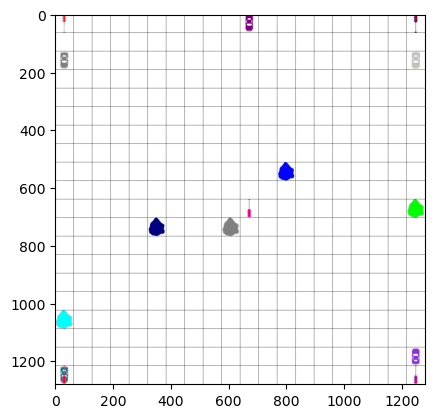

In [41]:
from matplotlib import pyplot as plt
# Convert frame to numpy array
frame_np = np.array(frames[0])
print(frame_np.shape)
# Turn the transparent background into white
frame_np[frame_np[:, :, 3] == 0] = 0
plt.imshow(frame_np)